# Unsupervised Class Identification


* **Products used:** 
[gm_s2_annual](https://explorer.digitalearth.africa/gm_s2_annual), 
[gm_s2_semiannual](https://explorer.digitalearth.africa/gm_s2_semiannual), 
[fc_ls_summary_annual](https://explorer.digitalearth.africa/fc_ls_summary_annual),


## Background

## Description

The goal in this set of notebooks is to investigate whether unsupervised learning can be used identify individual crop-types in Niger.


---

## Getting Started

To run this analysis, run all the cells in the notebook, starting with the "**Load packages**" cell.

### Load packages

In [1]:
import os
import pickle

import datacube
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rioxarray
import xarray as xr
from datacube.utils import geometry
from datacube.utils.geometry import CRS, Geometry
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.classification import sklearn_flatten, sklearn_unflatten
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import rgb
from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.temporal import temporal_statistics, xr_phenology
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

### Set up a Dask cluster

Dask can be used to better manage memory use and conduct the analysis in parallel. 
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

To use Dask, set up the local computing cluster using the cell below.

In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:37351 Dashboard: /user/victoria@kartoza.com/proxy/8787/status,Cluster Workers: 1 Cores: 15 Memory: 104.37 GB


### Analysis parameters

The following cell sets important parameters for the analysis:

* `vector_file`: file path for the shapefile containing the polygon for the boundary of the area of interest
* `attribute_col`: The column in the "vector_file" containing the names of the 'urban commune' or FR 'commune urbaine', 'rural commune' or FR 'commune rurale', and 'administrative post' or FR 'poste administratif'
* `commune`: In this analysis, we'll select a Niger commune/administrative post, to mask the dataset and analysis.
* `time` : This is the time period of interest to load data for.
* `resolution` : The spatial resolution, in metres, to resample the satellite data to. 
* `output_crs` : The coordinate reference system that the loaded data is to be reprojected to.
* `dask_chunks`: the size of the dask chunks, dask breaks data into manageable chunks that can be easily stored in memory, e.g. dict(x=1000,y=1000)
* `output_dir` : The directory in which to store results from the analysis.
* `no_of_clusters` : The number of clusters to form as well as the number of centroids generated in the K-Means clustering.

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.

In [3]:
vector_file = "data/boundary_data/communes_etude.geojson"
attribute_col = "NOM_COM"

# Select a commune/adminstrative post, a complete list of communes/adminstrative posts is available below.
commune = "BIRNI NGAOURE"

# Time period of interest.
time = "2021"

# Resolution and CRS to reproject data to.
resolution = (-20, 20)
output_crs = "EPSG:6933"

# Size of dask chunks.
dask_chunks = {"time": 1, "x": 500, "y": 500}

# Create the output directory to store the results.
output_dir = "results"
os.makedirs(output_dir, exist_ok=True)

# Specify the number of clusters to form as well as the number of centroids to generate in the K-Means Clustering.
no_of_clusters = 15

### Connect to the datacube

Connect to the datacube so we can access DE Africa data. 
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [4]:
dc = datacube.Datacube(app="unsupervised_class_identification")

### Load the Niger Communes shapefile

This shapefile contains polygons for the boundaries of Niger communes and will allows us to calculate ..  within a chosen commune/adminstrative post.

In [5]:
# Load the shapefile for the area of interest as a GeoDataFrame.
niger_communes = gpd.read_file(vector_file)
niger_communes.explore()

### List communes

You can change the `commune` in the analysis parameters cell to any Niger commune/administrative post. 
A complete list is printed below.


In [6]:
print(np.unique(niger_communes[attribute_col]))

['BIRNI NGAOURE' 'FABIDJI' 'FAKARA' 'HARIKANASSOU' 'KANKANDI' 'KIOTA'
 'KOYGOLO' 'NGONGA' 'TAGAZAR']


### Setup polygon

The commune selected needs to be transformed into a geometry object to be used in the `dc.load()` function.

In [7]:
idx = niger_communes[niger_communes[attribute_col] == commune].index[0]
geom = Geometry(geom=niger_communes.iloc[idx].geometry, crs=niger_communes.crs)

## Defining feature layers

To create the desired feature layers for the K-means clustering,  we define the `feature_func`.

*   `feature_func`: A function for generating feature layers that is applied to the data within the bounds of the input geometry. The feature_func must accept a dc_query dictionary, and return a single xarray.Dataset or xarray.DataArray containing 2D coordinates (i.e x, y - no time dimension). e.g.

        def feature_function(query):
            dc = datacube.Datacube(app='feature_layers')
            ds = dc.load(**query)
            ds = ds.mean('time')
            return ds

Below, we will define a more complicated feature layer function than the brief example shown above. 

In [8]:
# Generate a datacube query object from the analysis parameters above.
query = {
    "geopolygon": geom,
    "time": time,
    "resolution": resolution,
    "output_crs": output_crs,
    "dask_chunks": dask_chunks,
}

# Pickle the query for use in next notebook.
commune_name = commune.replace(" ", "_")
pickled_query = f"{output_dir}/{commune_name}_query_{time}.pickle"
with open(pickled_query, "wb") as f:
    pickle.dump(query, f)

In [9]:
# Define functions to load features.
def feature_layers(query):

    # Connnect to datacube.
    dc = datacube.Datacube(app="unsupervised_class_identification")
    

    # ----------------- Sentinel-2 Annual Geomedian -----------------

    # Sentinel-2 Annual and Bi-annual GeoMAD measurements.
    s2_measurements = [
        "blue",
        "green",
        "red",
        "nir",
        "swir_1",
        "swir_2",
        "red_edge_1",
        "red_edge_2",
        "red_edge_3",
        "BCMAD",
        "EMAD",
        "SMAD",
    ]

    # Load Sentinel-2 Annual Geomedian.
    ds_s2_annual_geomad = dc.load(
        product="gm_s2_annual", measurements=s2_measurements, **query
    )

    # Calculate some band indices.
    ds_s2_annual_geomad = calculate_indices(
        ds_s2_annual_geomad,
        index=["NDVI", "LAI", "SAVI", "MSAVI", "MNDWI"],
        drop=False,
        collection="s2",
    ).squeeze()

    # ----------------- Sentinel-2 Bi-Annual Geomedian -----------------

    # Load Sentinel-2 Bi-Annual Geomedian.
    ds_s2_semiannual_geomad = dc.load(
        product="gm_s2_semiannual",
        measurements=s2_measurements,
        **query,
    )

    # Split into two seperate datasets Jan-Jun and Jul-Dec.
    ds_janjun_geomad = (
        ds_s2_semiannual_geomad.isel(time=0)
        .reset_coords()
        .drop_vars(["time", "spatial_ref"])
    )
    ds_juldec_geomad = (
        ds_s2_semiannual_geomad.isel(time=1)
        .reset_coords()
        .drop_vars(["time", "spatial_ref"])
    )

    # Rename the dataset variables.
    janjun_rename_dict = {key: f"janjun_{key}" for key in list(ds_janjun_geomad.keys())}
    ds_janjun_geomad = ds_janjun_geomad.rename(name_dict=janjun_rename_dict)

    juldec_rename_dict = {key: f"juldec_{key}" for key in list(ds_juldec_geomad.keys())}
    ds_juldec_geomad = ds_juldec_geomad.rename(name_dict=juldec_rename_dict)

    # ----------------- S1 RADAR -----------------

    # Load Sentinel-1 data.
    #     ds_S1 = dc.load(
    #         product="s1_rtc",
    #         measurements=["vv", "vh", "mask"],
    #         group_by="solar_day",
    #         sat_orbit_state="ascending",
    #         **query,
    #     )

    # Get the temporal mean (mean over time) for the VH and VV polarizations.
    #     mean_vv = ds_S1.vv.where(ds_S1.mask == 1).mean(dim="time")
    #     mean_vh = ds_S1.vh.where(ds_S1.mask == 1).mean(dim="time")

    # Merge the temporal mean xarray.DataArrays into one xarray.Dataset.
    #     ds_S1_mean = xr.merge([mean_vv, mean_vh])

    # ----------------- Fractional Cover Annual Summaries -----------------

    # Fractional Cover Annual Summary  measurements.
    fc_measurements = [
        # "pv_pc_10",
        # "pv_pc_50",
        "pv_pc_90",
        # "npv_pc_10",
        # "npv_pc_50",
        "npv_pc_90",
        # "bs_pc_10",
        # "bs_pc_50",
        "bs_pc_90",
    ]

    # Load the Fractional Cover Annual Summary.
    ds_annual_fc = dc.load(
        product="fc_ls_summary_annual",
        measurements=fc_measurements,
        **query,
    )

    # ----------------- Temporal Statistics -----------------
    # Calculate these on NDVI over the year

    #     # Set parameters
    #     veg_index = "NDVI"
    #     resample_period = "2W"
    #     window = 4

    #     # Load S2 for query
    #     ds_S2 = load_ard(
    #         dc=dc,
    #         products=["s2_l2a"],
    #         measurements=["red", "nir"],
    #         mask_filters=[("opening", 3), ("dilation", 3)],
    #         **query,
    #         verbose=False,
    #     )

    #     # Calculate NDVI
    #     ds_S2 = calculate_indices(ds_S2, index=veg_index, collection="s2")

    #     # Smooth the NDVI over time
    #     ds_smooth = (
    #         ds_S2[veg_index]
    #         .resample(time=resample_period)
    #         .median()
    #         .rolling(time=window, min_periods=1)
    #         .mean()
    #     )

    #     statistics = [
    #         "discordance",
    #         #"f_mean",
    #         #"median_change",
    #         #"abs_change",
    #         "complexity",
    #         #"central_diff",
    #     ]

    #     ds_stats = temporal_statistics(ds_smooth, statistics)

    # ----------------- MERGE -----------------

    # Merge the indiviual datasets into one.
    ds_final = xr.merge(
        [
            ds_s2_annual_geomad,
            ds_janjun_geomad,
            ds_juldec_geomad,
            ds_annual_fc,
        ]  # ds_S1_mean
    )

    return ds_final

## Load data using the feature layers function

In [10]:
data = feature_layers(query).squeeze(dim="time", drop=True)

## Mask using the DE Africa crop-mask

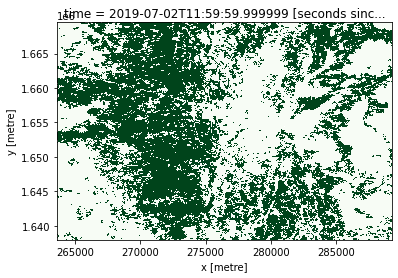

In [11]:
# Update the query as the crop-mask is only available for the year 2019.
query.update({'time' : '2019'})

# Now load the crop-mask using the query.
cm = dc.load(product='crop_mask',
             measurements=['filtered'],
             **query).filtered.squeeze()

cm.where(cm<255).plot.imshow(cmap='Greens', add_colorbar=False); # we filter to <255 to omit missing data

In [12]:
# Filter out the no data (255) and non-crop (0) pixels from the crop-mask `filtered` band and
# mask the data.
data = data.where(cm == 1)

## Mask using the commune boundary

Below, the commune polygon is rasterized so the `data` dataset is masked within that raster.

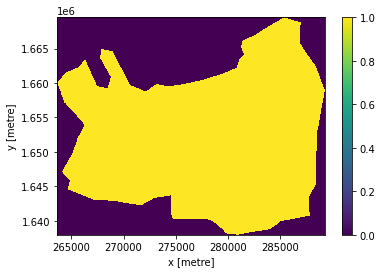

In [13]:
niger_communes = niger_communes.to_crs(output_crs)

mask = xr_rasterize(niger_communes[niger_communes[attribute_col] == commune], data)

# Plot the mask.
mask.plot();

In [14]:
# Mask the `data` dataset using the commune polygon
data = data.where(mask)

In [15]:
%%time
data = data.load()

CPU times: user 1.65 s, sys: 962 ms, total: 2.61 s
Wall time: 5.78 s


## Classification using K-means Clustering

### Run Standard Scaler for all parameters

In [16]:
# Use the `sklearn_flatten` function to convert the `data` xarray.Dataset into a 2 dimensional numpy array.
model_input = sklearn_flatten(data)

In [17]:
%%time
# Standardize the model_input (numpy array) by removing the mean and scaling to unit variance.
scaler = StandardScaler()
scaler.fit(model_input)
model_input = scaler.transform(model_input)

CPU times: user 332 ms, sys: 85.2 ms, total: 417 ms
Wall time: 411 ms


In [18]:
# Check for np.nan values in the scaled dataset.
np.unique(np.isnan(model_input))

array([False])

### Run K-Means Clustering

Perform k-means clustering on the standardized `model_input` numpy array. 

In [19]:
%%time
# Set up the kmeans classification by specifying the number of clusters
kmeans = KMeans(n_clusters=no_of_clusters, random_state=42)

# Perform Kmeans clustering on the 'model_input'.
# Begin iteratively computing the position of the clusters.
kmeans.fit(model_input)

# Use the sklearn kmeans `.predict` method to assign all the pixels of the `model_input` to a unique cluster.
flat_predicted = kmeans.predict(model_input)

# Use the sklearn_unflatten function to convert the flat predictions into a xarray DataArray.
predicted = sklearn_unflatten(flat_predicted, data)
predicted = predicted.transpose("y", "x")

CPU times: user 6min 17s, sys: 32.2 s, total: 6min 49s
Wall time: 39.6 s


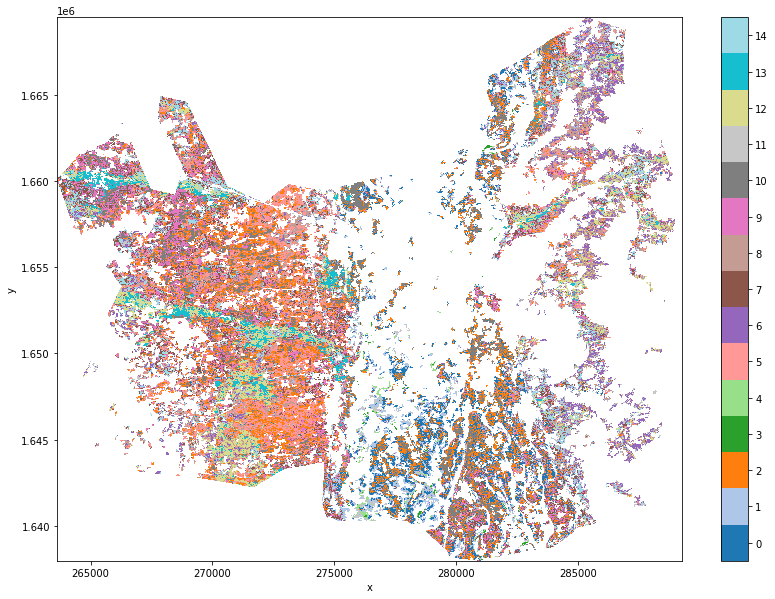

In [20]:
# Plot the predicted results.
cmap = (plt.cm.get_cmap("tab20", no_of_clusters))
bounds = np.arange(- 0.5, no_of_clusters, 1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(14,10))
im = predicted.plot.imshow(cmap=cmap, norm=norm, add_colorbar=False, ax=ax)
cbar=plt.colorbar(im);
cbar.set_ticks(range(no_of_clusters))

## Pickle the resulting data for the next notebook

In [21]:
# Pickle the K-Means clustering prediction results for use in next notebook.
pickled_prediction = (
    f"{output_dir}/{commune_name}_kmeans_{no_of_clusters}_predicted_{time}.pickle"
)

# Format data for pickle.
pickle_data = (
    predicted.x.to_numpy(),  # x-values
    predicted.y.to_numpy(),  # y-values
    predicted.to_numpy(),  # k-means prediction values
    data.crs,  # coordinate reference system
)

with open(pickled_prediction, "wb") as f:
    pickle.dump(pickle_data, f)

## Recommended next steps

To continue working through the notebooks in this workflow, go to the next notebook `02_group_classes_using_NDVI.ipynb`.

1. **Unsupervised Class Identification (this notebook)**
2. [Group Classes Using NDVI](02_group_classes_using_NDVI.ipynb.ipynb)
3. [Reclassify Unsupervised NDVI](03_reclassify_unsupervised_map_NDVI_classes.ipynb)

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to repoart an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [22]:
print(datacube.__version__)

1.8.6


**Last Tested:**

In [23]:
from datetime import datetime

datetime.today().strftime("%Y-%m-%d")

'2022-06-15'

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
